D'après une étude VIF, il faudrait supprimer les colonnes ZipCode, Latitude, Longitude

In [1]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn import model_selection

import math
# Evaluate
from sklearn.metrics import r2_score,max_error,mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

# Amélioration que nous allons apporter :

Le modèle précédent n'était composé de seulement un seul jeu de données, celui des relevés de 2016.
Nous avons à notre disposition de nouveaux jeux de données : 
- 2015, 2016, 2017, 2019, 2020

Nous allons procéder au même preprocessing que pour 2016, et rajouter une nouvelle colonne (Année) qui ne sera appliqué seulement pour l'application, ajoutant ainsi une **fonctionnalité** (Visulaisation donnée par année)

In [2]:
df_2015 = pd.read_csv("data/2015_Building_Energy_Benchmarking.csv")
df_2017 = pd.read_csv("data/2017_Building_Energy_Benchmarking.csv")
df_2019 = pd.read_csv("data/2019_Building_Energy_Benchmarking.csv")

### 2015

In [58]:
# Outlier cleaned
data_cleaned = df_2015[df_2015['Outlier'].isnull()]

# Drop features qui me semble inutile
data_cleaned  = data_cleaned.drop(["ListOfAllPropertyUseTypes","Location","OtherFuelUse(kBtu)","OSEBuildingID","TaxParcelIdentificationNumber","PropertyName" ,'Outlier', 'YearsENERGYSTARCertified', "Comment", "GHGEmissionsIntensity(kgCO2e/ft2)", "SiteEnergyUse(kBtu)","DefaultData", "ComplianceStatus" ], axis=1)

# Drop des lignes "Multifamily"
data_cleaned = data_cleaned[~data_cleaned['BuildingType'].str.contains("Multifamily", na=False) & ~data_cleaned['PrimaryPropertyType'].str.contains("Multifamily", na=False)]

# Drop des colonnes doubles avec unités différentes
data_cleaned.drop(['Electricity(kWh)', 'NaturalGas(therms)'], axis=1, inplace=True)

# Drop des features météorologiques: 
data_cleaned.drop(['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)'], axis=1, inplace=True)  

# Création de l'âge des bâtiments:
data_cleaned['BuildingAge'] = data_cleaned['DataYear'] - data_cleaned['YearBuilt']
data_cleaned.drop(['YearBuilt', "DataYear"], axis=1, inplace=True)

# Drop des features fortement corrélées:
data_cleaned.drop(['LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'], axis = 1, inplace=True)
data_cleaned.drop(['PropertyGFABuilding(s)', 'SourceEUI(kBtu/sf)', 'Electricity(kBtu)','SiteEUI(kBtu/sf)','NaturalGas(kBtu)', "NumberofBuildings"], axis = 1, inplace=True)

# Suppression des lignes =0 ou <0
data_cleaned = data_cleaned[~(data_cleaned['GHGEmissions(MetricTonsCO2e)']<=0)]

# Drop nan de la target
data_cleaned = data_cleaned[~(data_cleaned['GHGEmissions(MetricTonsCO2e)'].isnull())]

# drop de la seule data dans cette catégorie
data_cleaned = data_cleaned[~(data_cleaned.BuildingType=="Nonresidential WA")]

# Correction des quartiers en double
data_cleaned['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
data_cleaned['Neighborhood']=data_cleaned['Neighborhood'].map(lambda x: x.upper())

# Rename en TOTALGHGEmissions
data_cleaned = data_cleaned.rename(columns={'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions'})

print(data_cleaned.shape)

df_2015_cleaned = data_cleaned
print(f'Il y a actuellement {df_2015_cleaned.isna().sum()} valeurs NaN dans le DataFrame entier')

(1610, 11)
Il y a actuellement BuildingType             0
PrimaryPropertyType      0
CouncilDistrictCode      0
Neighborhood             0
NumberofFloors           8
PropertyGFATotal         0
PropertyGFAParking       0
ENERGYSTARScore        518
SteamUse(kBtu)           0
TotalGHGEmissions        0
BuildingAge              0
dtype: int64 valeurs NaN dans le DataFrame entier


In [4]:
data_cleaned.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)',
       'TotalGHGEmissions', 'BuildingAge'],
      dtype='object')

### 2017

In [56]:
# Outlier cleaned
data_cleaned = df_2017[df_2017['Outlier'].isnull()]

# Drop features qui me semble inutile
data_cleaned  = data_cleaned.drop(["ListOfAllPropertyUseTypes","Address","City","OSEBuildingID","TaxParcelIdentificationNumber","PropertyName" ,"State",'Outlier', 'YearsENERGYSTARCertified', "GHGEmissionsIntensity", "SiteEnergyUse(kBtu)","DefaultData", "ComplianceStatus" ], axis=1)

# Drop des lignes "Multifamily" dans deux colonnes (BuildingType et Multifamily)
data_cleaned = data_cleaned[~data_cleaned['BuildingType'].str.contains("Multifamily", na=False) & ~data_cleaned['PrimaryPropertyType'].str.contains("Multifamily", na=False)]

# Drop des colonnes doubles avec unités différentes
data_cleaned.drop(['Electricity(kWh)', 'NaturalGas(therms)'], axis=1, inplace=True)

# Drop des features météorologiques: 
data_cleaned.drop(['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)'], axis=1, inplace=True)

# Création de l'âge des bâtiments:
data_cleaned['BuildingAge'] = data_cleaned['DataYear'] - data_cleaned['YearBuilt']
data_cleaned.drop(['YearBuilt', "DataYear"], axis=1, inplace=True)

# Drop des features fortement corrélées:
data_cleaned.drop(['LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'], axis = 1, inplace=True)
data_cleaned.drop(['PropertyGFABuilding(s)', 'SourceEUI(kBtu/sf)', 'Electricity(kBtu)','SiteEUI(kBtu/sf)','NaturalGas(kBtu)', "NumberofBuildings"], axis = 1, inplace=True)

# Suppression des lignes =0 ou <0
data_cleaned = data_cleaned[~(data_cleaned.TotalGHGEmissions<=0)]

# Drop nan de la target
data_cleaned = data_cleaned[~(data_cleaned.TotalGHGEmissions.isnull())]

# drop de la seule data dans cette catégorie
data_cleaned = data_cleaned[~(data_cleaned.BuildingType=="Nonresidential WA")]

# Correction des quartiers en double
data_cleaned = data_cleaned.dropna(subset=['Neighborhood'])
data_cleaned['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
data_cleaned['Neighborhood']=data_cleaned['Neighborhood'].map(lambda x: x.upper())

# Suppression de "ZipCode", "Latitude", "Longitude"
data_cleaned.drop(['ZipCode','Latitude', 'Longitude'], axis=1, inplace=True)

print(data_cleaned.shape)

df_2017_cleaned = data_cleaned
print(f'Il y a actuellement {df_2017_cleaned.isna().sum()} valeurs NaN dans le DataFrame entier')

(1641, 11)
Il y a actuellement BuildingType              0
PrimaryPropertyType       0
CouncilDistrictCode       0
Neighborhood              0
NumberofFloors            7
PropertyGFATotal          0
PropertyGFAParking       66
ENERGYSTARScore         574
SteamUse(kBtu)         1520
TotalGHGEmissions         0
BuildingAge               1
dtype: int64 valeurs NaN dans le DataFrame entier


### 2019

In [57]:
# Drop features qui me semble inutile
data_cleaned  = df_2019.drop(["Address","City","OSEBuildingID","TaxParcelIdentificationNumber", "State", "GHGEmissionsIntensity", "SiteEnergyUse(kBtu)", "ComplianceStatus" ], axis=1)

# Drop des lignes "Multifamily"
data_cleaned = data_cleaned[~data_cleaned['BuildingType'].str.contains("Multifamily", na=False) & ~data_cleaned['PrimaryPropertyType'].str.contains("Multifamily", na=False)]

# Drop des colonnes doubles avec unités différentes
data_cleaned.drop(['Electricity(kWh)', 'NaturalGas(therms)'], axis=1, inplace=True)

# Drop des features météorologiques: 
data_cleaned.drop(['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)'], axis=1, inplace=True)

# Création de l'âge des bâtiments:
data_cleaned['BuildingAge'] = data_cleaned['DataYear'] - data_cleaned['YearBuilt']
data_cleaned.drop(['YearBuilt', "DataYear"], axis=1, inplace=True)

# Drop des features fortement corrélées:
data_cleaned.drop(['LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'], axis = 1, inplace=True)
data_cleaned.drop(['PropertyGFABuilding(s)', 'SourceEUI(kBtu/sf)', 'Electricity(kBtu)','SiteEUI(kBtu/sf)','NaturalGas(kBtu)'], axis = 1, inplace=True)

# Suppression des lignes =0 ou <0
data_cleaned = data_cleaned[~(data_cleaned.TotalGHGEmissions<=0)]

# Drop nan de la target
data_cleaned = data_cleaned[~(data_cleaned.TotalGHGEmissions.isnull())]

# drop de la seule data dans cette catégorie
data_cleaned = data_cleaned[~(data_cleaned.BuildingType=="Nonresidential WA")]

# Correction des quartiers en double
data_cleaned = data_cleaned.dropna(subset=['Neighborhood'])
data_cleaned['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
data_cleaned['Neighborhood']=data_cleaned['Neighborhood'].map(lambda x: x.upper())

# Suppression de "ZipCode", "Latitude", "Longitude"
data_cleaned.drop(['ZipCode','Latitude', 'Longitude', "BuildingName", "EPAPropertyType", "ComplianceIssue"], axis=1, inplace=True)

df_cols = df_2017_cleaned.columns

data_cleaned = data_cleaned[df_cols]

print(data_cleaned.shape)

df_2019_cleaned = data_cleaned
print(f'Il y a actuellement {df_2019_cleaned.isna().sum()} valeurs NaN dans le DataFrame entier')

(1647, 11)
Il y a actuellement BuildingType             0
PrimaryPropertyType      0
CouncilDistrictCode      4
Neighborhood             0
NumberofFloors           0
PropertyGFATotal         0
PropertyGFAParking       0
ENERGYSTARScore        587
SteamUse(kBtu)           0
TotalGHGEmissions        0
BuildingAge              0
dtype: int64 valeurs NaN dans le DataFrame entier


# Preprocessing

In [7]:
df = pd.read_csv("data/data_cleaned.csv")
df.drop(['ZipCode','Latitude', 'Longitude'], axis=1, inplace=True)

In [8]:
len(df.columns)

11

In [9]:
df.shape

(1639, 11)

### Création Jeu de donnée principale

Nous allons maintenant concaténer les deux DataFrames

In [10]:
df_big = pd.concat([df,df_2015_cleaned,df_2017_cleaned,df_2019_cleaned], axis = 0)

In [11]:
df_big

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SteamUse(kBtu),TotalGHGEmissions,BuildingAge
0,NonResidential,Hotel,7.0,DOWNTOWN,12.0,88434,0.0,60.0,2003882.00,249.98,89.0
1,NonResidential,Hotel,7.0,DOWNTOWN,11.0,103566,15064.0,61.0,0.00,295.86,20.0
2,NonResidential,Hotel,7.0,DOWNTOWN,41.0,956110,196718.0,43.0,21566554.00,2089.28,47.0
3,NonResidential,Hotel,7.0,DOWNTOWN,10.0,61320,0.0,56.0,2214446.25,286.43,90.0
4,NonResidential,Hotel,7.0,DOWNTOWN,18.0,175580,62000.0,75.0,0.00,505.01,36.0
...,...,...,...,...,...,...,...,...,...,...,...
3563,NonResidential,Hotel,1.0,DOWNTOWN,45.0,1400666,338415.0,76.0,0.00,2569.30,1.0
3565,SPS-District K-12,K-12 School,1.0,NORTHWEST,3.0,162182,0.0,81.0,0.00,55.60,1.0
3567,NonResidential,Office,1.0,LAKE UNION,12.0,254218,58820.0,85.0,0.00,162.10,1.0
3577,NonResidential,Senior Care Community,1.0,NORTH,3.0,71461,10032.0,96.0,0.00,13.80,1.0


## Préparation de la donnée

* X train et test*

Nous allons scale certaines données, et encoder les données catégoriques :

Données à scale : 'CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'BuildingAge'

Donnée à encoder : 'BuildingType', 'PrimaryPropertyType', 'Neighborhood'

### Scaling des données

In [12]:
X_to_scale = df.drop(['TotalGHGEmissions', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood'], axis=1)

#### Compléter ENERGYSTARScore

In [13]:
print(f'Il y a actuellement {X_to_scale.isna().sum()[4]} valeurs NaN dans ENERGYSTARScore')

Il y a actuellement 560 valeurs NaN dans ENERGYSTARScore


In [14]:
imputer = KNNImputer(n_neighbors=5)

energystar = X_to_scale.values
new_X_to_scale = pd.DataFrame(imputer.fit_transform(energystar), columns = X_to_scale.columns)

In [15]:
print(f'Il y a actuellement {new_X_to_scale.isna().sum()[4]} valeurs NaN dans ENERGYSTARScore')

Il y a actuellement 0 valeurs NaN dans ENERGYSTARScore


#### Continuation du scaling

In [16]:
to_scale = new_X_to_scale.values

In [17]:
X_to_encode = df.drop(['TotalGHGEmissions',  'CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal',
                       'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'BuildingAge'], axis = 1)

In [18]:
#X = df.drop('TotalGHGEmissions', axis=1)
y = df['TotalGHGEmissions']

#### Scaling

In [19]:
rs = MinMaxScaler()
rs = rs.fit(to_scale)
to_scale = rs.transform(to_scale)

In [20]:
X_scaled = pd.DataFrame(to_scale, columns = X_to_scale.columns)

In [21]:
X_scaled

,CouncilDistrictCode,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SteamUse(kBtu),BuildingAge
0,1.000000,0.121212,0.008288,0.000000,0.595960,0.014850,0.765217
1,1.000000,0.111111,0.009913,0.029387,0.606061,0.000000,0.165217
2,1.000000,0.414141,0.101497,0.383759,0.424242,0.159819,0.400000
3,1.000000,0.101010,0.005375,0.000000,0.555556,0.016410,0.773913
4,1.000000,0.181818,0.017649,0.120950,0.747475,0.000000,0.304348
...,...,...,...,...,...,...,...
1634,0.166667,0.010101,0.000108,0.000000,0.454545,0.000000,0.217391
1635,0.166667,0.010101,0.000507,0.000000,0.660606,0.000000,0.095652
1636,1.000000,0.010101,0.000201,0.000000,0.660606,0.000000,0.356522
1637,0.000000,0.010101,0.000303,0.000000,0.660606,0.000000,0.226087


#### Encoding

In [22]:
# OneHotEncoder
ohe = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(ohe.fit_transform(X_to_encode), columns=ohe.get_feature_names())

# One-hot encoding removed index; put it back
OH_cols.index = X_to_encode.index

num_trainset = X_to_encode.drop(columns={'BuildingType', 'PrimaryPropertyType', 'Neighborhood'}, axis = 1)

# Add one-hot encoded columns to numerical features
X_encoded = pd.concat([num_trainset, OH_cols], axis=1)
X_encoded

,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_SPS-District K-12,x1_Distribution Center,x1_Hospital,x1_Hotel,x1_K-12 School,x1_Laboratory,x1_Large Office,...,x2_DOWNTOWN,x2_EAST,x2_GREATER DUWAMISH,x2_LAKE UNION,x2_MAGNOLIA / QUEEN ANNE,x2_NORTH,x2_NORTHEAST,x2_NORTHWEST,x2_SOUTHEAST,x2_SOUTHWEST
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1635,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1636,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1637,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Assemblage des DataFrames

In [23]:
X = pd.concat([X_scaled, X_encoded], axis=1)

In [24]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y,test_size=0.3)

# Modélisation

In [25]:
results = pd.DataFrame(columns=['Modèle','RMSE','Inference_duration (microsecs)'])

## RandomForest Regressor

In [26]:
parameters = {
    'n_estimators' : [10,50,100,300,500],
    'min_samples_leaf' : [1,3,5,10], 
    'max_features': ['auto', 'sqrt']
}

In [27]:
rfr = GridSearchCV(RandomForestRegressor(), param_grid = parameters, verbose=True, cv=5)
rfr.fit(X_train, Y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=True)

In [28]:
rfr.best_params_

{'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 500}

In [29]:
#results = results.append({
#    'Modèle' : 'Random Forest',
#    'RMSE' : rmse_estimator_rfr,
#    }
#    ,ignore_index=True)

In [30]:
results

,Modèle,RMSE,Inference_duration (microsecs)


In [31]:
coefficients = abs(rfr.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variables']), 
                      pd.DataFrame(coefficients, columns = ['Coefficients'])), axis = 1).sort_values(by='Coefficients', ascending = False)

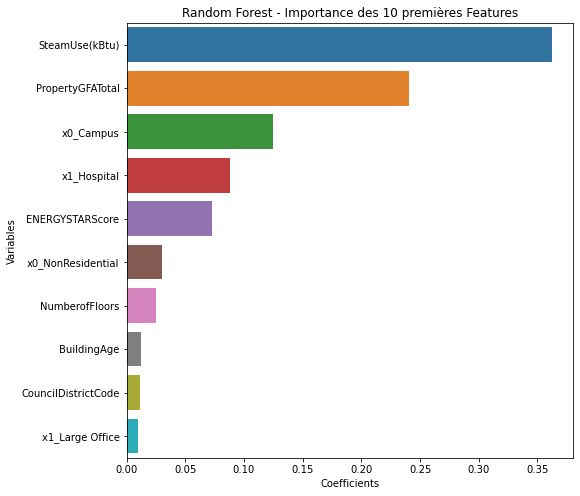

In [32]:
plt.figure(figsize=(8,8))
plt.title('Random Forest - Importance des 10 premières Features')
sns.barplot(y = liste_coefs_rer['Variables'].head(10),
            x = liste_coefs_rer['Coefficients'].head(10))
plt.show()

In [33]:
y_pred = rfr.predict(X_test)

In [34]:
Y_test.describe()

count      492.000000
mean       172.616972
std        648.414489
min          0.810000
25%         16.302500
50%         44.580000
75%        132.402500
max      10734.570000
Name: TotalGHGEmissions, dtype: float64

In [35]:
verif = pd.DataFrame(data=Y_test)
verif['y_pred'] = y_pred

verif.columns = ['Y_test','y_pred']

In [36]:
verif.y_pred.describe()

count     492.000000
mean      197.643580
std       482.384296
min         8.163158
25%        40.723121
50%        67.697945
75%       171.737548
max      6621.232683
Name: y_pred, dtype: float64

In [37]:
print("R²:", r2_score(Y_test, y_pred))
print("MAE:", mean_absolute_error(Y_test, y_pred))
#print("MSE:", mean_squared_error(Y_test, y_pred))
print("RMSE:", mean_squared_error(Y_test, y_pred, squared=False))

R²: 0.5935572070792325
MAE: 120.08795173414708
RMSE: 412.96250254448614


In [38]:
Y_test

932      86.81
142     309.60
682      10.83
110      61.21
1304     27.93
         ...  
463      98.43
898      44.89
743      43.13
1073    110.66
578      89.53
Name: TotalGHGEmissions, Length: 492, dtype: float64

In [39]:
best_rfr = RandomForestRegressor(max_features="sqrt", min_samples_leaf=1, n_estimators = 300)
best_rfr.fit(X_train, Y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=300)

In [40]:
y_pred_best = best_rfr.predict(X_test)

In [41]:
print("R²:", r2_score(Y_test, y_pred_best))
print("MAE:", mean_absolute_error(Y_test, y_pred_best))
#print("MSE:", mean_squared_error(Y_test, y_pred))
print("RMSE:", mean_squared_error(Y_test, y_pred_best, squared=False))

R²: 0.6704345677351937
MAE: 122.01022012195126
RMSE: 371.8619410527527


## XGboostRegressor

In [42]:
from xgboost import XGBRegressor

In [43]:
parameters = {
    'n_estimators' : [10,20,50,100,500,1000,2000]
}
xgb = GridSearchCV(XGBRegressor(),
                        param_grid = parameters,
                        cv = 5,
                        verbose=False)
xgb.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [44]:
xgb.best_params_

{'n_estimators': 10}

In [45]:
best_xgb = XGBRegressor(n_estimators = 10, booster="gblinear")
best_xgb.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=4, num_parallel_tree=None, predictor=None,
             random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

In [46]:
xgb_pred = best_xgb.predict(X_test)

print("R²:", r2_score(Y_test, xgb_pred))
print("MAE:", mean_absolute_error(Y_test, xgb_pred))
#print("MSE:", mean_squared_error(Y_test, xgb_pred))
print("RMSE:", mean_squared_error(Y_test, xgb_pred, squared=False))

R²: 0.7479774933520549
MAE: 120.37690279946096
RMSE: 325.18504828937085


In [47]:
XGBRegressor.feature_importances_

## SHAP values

## Random Forest avec nouveau DataFrame

In [48]:
X_to_scale = df_big.drop(['TotalGHGEmissions', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood'], axis=1)

In [51]:
X_to_scale

,CouncilDistrictCode,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SteamUse(kBtu),BuildingAge
0,7.0,12.0,88434,0.0,60.0,2003882.00,89.0
1,7.0,11.0,103566,15064.0,61.0,0.00,20.0
2,7.0,41.0,956110,196718.0,43.0,21566554.00,47.0
3,7.0,10.0,61320,0.0,56.0,2214446.25,90.0
4,7.0,18.0,175580,62000.0,75.0,0.00,36.0
...,...,...,...,...,...,...,...
3563,1.0,45.0,1400666,338415.0,76.0,0.00,1.0
3565,1.0,3.0,162182,0.0,81.0,0.00,1.0
3567,1.0,12.0,254218,58820.0,85.0,0.00,1.0
3577,1.0,3.0,71461,10032.0,96.0,0.00,1.0


#### Nomnre de NaN dans le DataFrame et "ENERGYSTARScore"

In [54]:
print(f'Il y a actuellement {X_to_scale.isna().sum()} valeurs NaN dans le DataFrame entier')

Il y a actuellement CouncilDistrictCode       4
NumberofFloors           15
PropertyGFATotal          0
PropertyGFAParking       66
ENERGYSTARScore        2239
SteamUse(kBtu)         1520
BuildingAge               1
dtype: int64 valeurs NaN dans le DataFrame entier


Finalement, on remarque que le jeu de données de l'année 2017 est remplie de données manquante. Nous allons nous en séparer.

In [53]:
print(f'Il y a actuellement {X_to_scale.isna().sum()[4]} valeurs NaN dans ENERGYSTARScore')

Il y a actuellement 2239 valeurs NaN dans ENERGYSTARScore


### Suppression de 2017 :

In [59]:
new_df = pd.concat([df,df_2015_cleaned,df_2019_cleaned], axis = 0)

#### Vérif valeurs nulles

In [61]:
print(f'Il y a actuellement {new_df.isna().sum()} valeurs NaN dans le DataFrame entier')

Il y a actuellement BuildingType              0
PrimaryPropertyType       0
CouncilDistrictCode       4
Neighborhood              0
NumberofFloors            8
PropertyGFATotal          0
PropertyGFAParking        0
ENERGYSTARScore        1665
SteamUse(kBtu)            0
TotalGHGEmissions         0
BuildingAge               0
dtype: int64 valeurs NaN dans le DataFrame entier


Nous allons supprimer les lignes manquantes de **CouncilDistrictCode**, **NumberofFloors**, et utiliser le **KNNImputer** pour compléter celle d'ENERGYSTARScore

### Suppression lignes vide, et utilisation KNNImputer

In [68]:
new_df.dropna(subset=['CouncilDistrictCode','NumberofFloors'], inplace=True)

In [70]:
X_to_scale = new_df.drop(['TotalGHGEmissions', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood'], axis=1)

In [71]:
imputer = KNNImputer(n_neighbors=5)

energystar = X_to_scale.values
new_X_to_scale = pd.DataFrame(imputer.fit_transform(energystar), columns = X_to_scale.columns)

#### Encoding avant le scaling

In [73]:
to_scale = new_X_to_scale.values

In [74]:
X_to_encode = new_df.drop(['TotalGHGEmissions',  'CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal',
                       'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'BuildingAge'], axis = 1)

In [75]:
y = new_df['TotalGHGEmissions']

### Scaling

In [76]:
rs = MinMaxScaler()
rs = rs.fit(to_scale)
to_scale = rs.transform(to_scale)

In [77]:
X_scaled = pd.DataFrame(to_scale, columns = X_to_scale.columns)
X_scaled

,CouncilDistrictCode,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SteamUse(kBtu),BuildingAge
0,1.0,0.121212,0.008288,0.000004,0.595960,0.000343,0.721311
1,1.0,0.111111,0.009913,0.021939,0.606061,0.000000,0.155738
2,1.0,0.414141,0.101497,0.286451,0.424242,0.003689,0.377049
3,1.0,0.101010,0.005375,0.000004,0.555556,0.000379,0.729508
4,1.0,0.181818,0.017649,0.090284,0.747475,0.000000,0.286885
...,...,...,...,...,...,...,...
4879,0.0,0.454545,0.149253,0.492780,0.757576,0.000000,0.000000
4880,0.0,0.030303,0.016210,0.000004,0.808081,0.000000,0.000000
4881,0.0,0.121212,0.026097,0.085654,0.848485,0.000000,0.000000
4882,0.0,0.030303,0.006464,0.014612,0.959596,0.000000,0.000000


#### Encoding

In [86]:
# OneHotEncoder
ohe = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(ohe.fit_transform(X_to_encode), columns=ohe.get_feature_names())

# One-hot encoding removed index; put it back
OH_cols.index = X_to_encode.index

num_trainset = X_to_encode.drop(columns={'BuildingType', 'PrimaryPropertyType', 'Neighborhood'}, axis = 1)

# Add one-hot encoded columns to numerical features
X_encoded = pd.concat([num_trainset, OH_cols], axis=1).reset_index()
X_encoded

,index,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_SPS-District K-12,x1_Adult Education,x1_Automobile Dealership,x1_Bank Branch,x1_College/University,x1_Convention Center,...,x2_NORTHWEST,x2_SHARED: BALLARD &AMP; LAKE UNION,x2_SHARED: BALLARD &AMP; NORTHWEST,x2_SHARED: CENTRAL &AMP; EAST,x2_SHARED: GREATER DUWAMISH &AMP; DELRIDGE NEIGHBORHOODS,x2_SHARED: LAKE UNION &AMP; NORTHWEST,x2_SHARED: NORTH &AMP; NORTHWEST,x2_SOUTHEAST,x2_SOUTHWEST,x2_WATER
0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,3563,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4880,3565,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4881,3567,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4882,3577,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Assemblage des DataFrames

In [87]:
X = pd.concat([X_scaled, X_encoded], axis=1)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y,test_size=0.3)

## Modélisation

In [88]:
results = pd.DataFrame(columns=['Modèle','RMSE','Inference_duration (microsecs)'])

### RandomForestRegressor

#### Mise en place du GridSearch

In [89]:
parameters = {
    'n_estimators' : [10,50,100,150,200,250,300,350,400,450,500],
    'min_samples_leaf' : [1,2,3,4,5,6,7,8,9,10], 
    'max_features': ['auto', 'sqrt']
}

In [90]:
rfr = GridSearchCV(RandomForestRegressor(), param_grid = parameters, verbose=True, cv=5)
rfr.fit(X_train, Y_train)

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


KeyboardInterrupt: 